# 5.3 基于迁移学习技术来识别极限小样本分类

## 采用段到段的模式从卷积基中提取特征

## 1 创建VGG16卷积基实例（即仅使用卷积层，而不使用全连接层作为分类器）

In [120]:
from keras.applications import VGG16

In [121]:
#创建VGG16实例，提前下载VGG16模型的h5文件，然后放置在C:\Users\Administrator\.keras\models
#include_top：是否包含全连接层
#weights：模型初始权重
conv_base = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (150,150,3))

### 通过函数summary回顾下卷积基的网络结构

In [122]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### vgg16的卷积核包含5部分：
### 第1-2部分：Conv2D x 2 + MaxPooling2D
### 第3-5部分：Conv2D x 3 + MaxPooling2D
### 卷积核的输出特征维度为 4 x 4 x 512, 我们需要在此基础上添加自定义的Dense层来实现分类器

## 2 使用预训练的VGG16模型的卷积基进行特征提取

In [123]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

### 设置训练集、验证集、测试集的图片目录

In [124]:
base_dir = 'D:/2-AI读书学习笔记/0-python深度学习/1-dataset_repo/极限样本迷你测试'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')

In [134]:
train_dir

'D:/2-AI读书学习笔记/0-python深度学习/1-dataset_repo/极限样本迷你测试\\train'

In [130]:
test_dir

'D:/2-AI读书学习笔记/0-python深度学习/1-dataset_repo/极限样本迷你测试\\test'

### 创建数据生成器实例

### 场景1：不使用数据增强技术

In [125]:
#实例化ImageDataGenerator，不使用数据增强技术
datagen = ImageDataGenerator(rescale = 1./255)

In [138]:
generator = datagen.flow_from_directory(train_dir,
                                        target_size = (150,150),
                                        batch_size = 1,
                                        class_mode = 'categorical')#因为是多分类问题，因此class_mode需从binary修改为categorical

Found 3 images belonging to 3 classes.


In [140]:
#特别注意，多分类问题，其label为n维数组，数组长度与类别数一致
i = 0
for fs,ls in generator:
    print(ls)
    i+=1
    if i >2:
        break

[[0. 0. 1.]]
[[1. 0. 0.]]
[[0. 1. 0.]]


### 场景2：使用数据增强技术

In [126]:
# #使用数据增强技术
# datagen = ImageDataGenerator(
#     rescale = 1./255,
#     rotation_range = 40,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     shear_range = 0.2,
#     zoom_range = 0.2,
#     horizontal_flip = True,
#     fill_mode = 'nearest')

### 定义特征提取函数
### 基于数据生成器将图像张量批量输入至卷积基，通过函数predict获取卷积基的特征张量
### 输入：提取图片样本目录；提取样本数
### 输出：返回VGG16卷积基输出的张量；样本对应的分类结果

In [141]:
#定义特征提取函数


#通过指定路径获取样本数进行特征提取
def extract_features(directory, sample_count):
    #初始化features,labels矩阵
    features_vgg16 = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count, 3)) #每个样本的分类结果为3维
    
    #生成器加载
    generator = datagen.flow_from_directory(directory,
                                           target_size = (150,150),
                                           batch_size = 1,
                                           class_mode = 'categorical')#因为是多分类问题，因此class_mode需从binary修改为categorical
    i = 0
    for fs,ls in generator:
        vgg16_output = conv_base.predict(fs) 
        features_vgg16[i] = vgg16_output
        labels[i] = ls
        i+=1
        if i >= sample_count:
            break
    
    return features_vgg16,labels
    

### 对训练集、验证集、测试集进行特征提取
### 训练集中，1张图片/类别
### 测试集中，3张图片/类别

In [142]:
#对训练集、验证集、测试集进行特征提取
train_features,train_labels = extract_features(train_dir,3)
test_features,test_labels = extract_features(test_dir,9)

Found 3 images belonging to 3 classes.


In [ ]:
train_features.shape

In [143]:
train_labels

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

## 3 创建自定义的分类器


### 3.1 展平卷积基张量
### 注意：VGG16特征提取后的形状为(samples, 4, 4, 512), 因此在输入到分类器之前需要先展平
### (样本数, 4, 4, 512) 四维张量 -----> (样本数, 4 x 4 x 512 = 8192)

In [144]:
trian_features_reshaped = np.reshape(train_features, (3, 8192))
test_features_reshaped = np.reshape(test_features, (9, 8192))

In [145]:
trian_features_reshaped.shape

(3, 8192)

### 3.2 建立自定义的Dense层
### （1）无论分类设计成什么样，分类器的输入的张量尺寸要与卷积基的输出张量尺寸保持一致，这样才能串联起来
### （2）可参考5.2节中的全连接层进行设计，即2个dense层串联而成
### （3）猫狗识别的二分类问题，因此最后一个dense层一定要选择sigmoid作为激活函数
### （4）为防止过拟合，可使用dropout正则化技术

In [146]:
from keras import models
from keras import layers
from keras import optimizers

### 方案1：全连接层分类器不使用Droupout

In [184]:
model_after_vgg16 = models.Sequential()
#与conv_base串接起来，故分类器的输入张量尺寸与卷积基的输出张量尺寸一致
model_after_vgg16.add(layers.Dense(256, activation = 'relu', input_dim = 4*4*512))
model_after_vgg16.add(layers.Dense(3, activation = 'softmax'))#因为是多元分类问题，所以最后一层的激活函数应将sigmoid修改为softmax

### 方案2：全连接层分类器使用Droupout

In [221]:
# model_after_vgg16 = models.Sequential()
# #与conv_base串接起来，故分类器的输入张量尺寸与卷积基的输出张量尺寸一致
# model_after_vgg16.add(layers.Dense(256, activation = 'relu', input_dim = 4*4*512))
# model_after_vgg16.add(layers.Dropout(0.5)) #降低过拟合
# model_after_vgg16.add(layers.Dense(3, activation = 'softmax'))#因为是多元分类问题，所以最后一层的激活函数应将sigmoid修改为softmax

### 3.3 编译模型

In [222]:
#本场景为多分类问题，因此loss function应将binary_corssentroy修改为categorical_crossentropy
model_after_vgg16.compile(optimizer = optimizers.RMSprop(lr = 2e-5), loss = 'categorical_crossentropy', metrics = ['acc'])

## 4 训练模型

In [223]:
#训练参数：
#-迭代次数
#-批量大小
#-验证集
import time
start = time.time()

history_model_after_vgg16 = model_after_vgg16.fit(trian_features_reshaped,train_labels, epochs = 30, batch_size =1)

end = time.time()
print("训练时间（s）：%d"%(end - start))

Epoch 1/30
3/3 [==============================] - 0s 11ms/step - loss: 0.6066 - acc: 0.6667
Epoch 2/30
3/3 [==============================] - 0s 12ms/step - loss: 1.2561 - acc: 0.3333
Epoch 3/30
3/3 [==============================] - 0s 13ms/step - loss: 0.7958 - acc: 0.6667
Epoch 4/30
3/3 [==============================] - 0s 13ms/step - loss: 1.4449 - acc: 0.3333
Epoch 5/30
3/3 [==============================] - 0s 11ms/step - loss: 0.7936 - acc: 0.6667
Epoch 6/30
3/3 [==============================] - 0s 12ms/step - loss: 0.2417 - acc: 1.0000
Epoch 7/30
3/3 [==============================] - 0s 12ms/step - loss: 0.6337 - acc: 0.6667
Epoch 8/30
3/3 [==============================] - 0s 12ms/step - loss: 0.7717 - acc: 0.6667
Epoch 9/30
3/3 [==============================] - 0s 12ms/step - loss: 0.7652 - acc: 0.6667
Epoch 10/30
3/3 [==============================] - 0s 13ms/step - loss: 0.5498 - acc: 0.6667
Epoch 11/30
3/3 [==============================] - ETA: 0s - loss: 0.2425 - acc

### 基于段到段的特征特取模式，模型训练时间约为19s

In [224]:
#model_after_vgg16.save('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/ch5_3_transfer_learning_1_convbase_classfication_without_data_augment.h5')
model_after_vgg16.save('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/ch5_3_transfer_learning_extreme_limited_samples_test_seg_to_seg_with_droupout.h5')

## 5 评估模型在测试集上的表现

### 5.1 测试单个图片

In [225]:
from keras.models import load_model
my_network = load_model('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/ch5_3_transfer_learning_extreme_limited_samples_test_seg_to_seg_without_data_augment.h5')

In [226]:
import numpy as np
def preprocess_img(img):
    x1 = image.img_to_array(img)
    x2 = x1 * 1./255
    x3 = np.expand_dims(x2, axis = 0)
    return x3


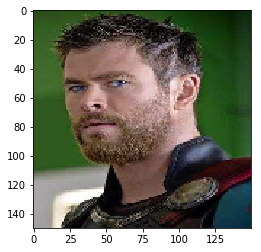

In [228]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
#指定图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/0-python深度学习/1-dataset_repo/极限样本迷你测试/test/thor/thor.3.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (150, 150))
plt.imshow(img2)

In [229]:
extracted_features = conv_base.predict(preprocess_img(img2))
input_features = np.reshape(extracted_features, (1,8192))
pred = my_network.predict(input_features)
pred

array([[0.17685623, 0.10000709, 0.72313666]], dtype=float32)

### 输出预测结果为所有类别下的概率

In [208]:
pred[0].argmax()

2

### 用argmax()取所有类别中最大概率值所对应的索引号，即为对应分类

### 5.2 查看模型在测试集的分类准确率

In [230]:
import os
from keras.preprocessing import image

classes = ['captain_america','iron_man','thor']
files_name = []
test_true_labels = []
test_pred_labels = []
test_pred_probs = []

for c in classes:
    test_class_dir = 'D:/2-AI读书学习笔记/0-python深度学习/1-dataset_repo/极限样本迷你测试/test/{}'.format(c)
    for f in os.listdir(test_class_dir):
        
        files_name.append(f)
        who = re.match("captain_america|iron_man|thor",f).group()
        test_true_labels.append(who)
        
        img_path = os.path.join(test_class_dir, f)
        img = image.load_img(img_path, target_size = (150, 150))
        #预处理图片&提取卷积基特征
        extracted_features = conv_base.predict(preprocess_img(img))
        #展平张量
        input_features = np.reshape(extracted_features, (1,8192))
        #模型预测
        pred = my_network.predict(input_features)
        test_pred_probs.append(pred[0].max())
        
        #根据预测输出判定预测类别
        pred_label = None
        class_index = pred[0].argmax()
        pred_label = classes[class_index]
        test_pred_labels.append(pred_label)  

In [231]:
import pandas as pd
df = pd.DataFrame(data={'file':files_name, 'true_label':test_true_labels,  'pred_label':test_pred_labels, 'pred_prob':test_pred_probs})
pred_error_records = df[df['true_label'] != df['pred_label']].shape[0]
error_rate = float(pred_error_records)/float(1000)
error_rate

0.0

### 测试集上分类错误率为 x%

### 5.3 查看测试集中9张图片的分类预测情况

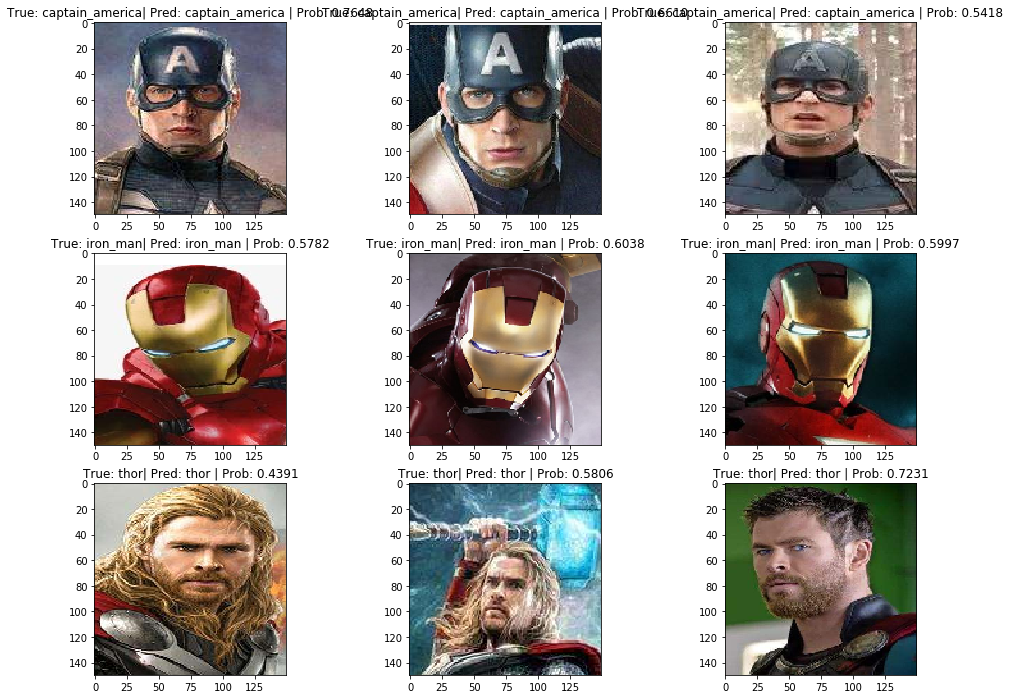

In [219]:
import re

files = list(df['file'])
true_labels =  list(df['true_label'])
pred_labels =  list(df['pred_label'])
pred_probs = list(df['pred_prob'])


import matplotlib.pyplot as plt
n_rows= 3
n_cols= 3 

#16个分类错误记录用4x4图片排布展现出来
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4*n_rows))

c = 0
for i in range(n_rows):
    for j in range(n_cols):
        
        who = re.match("captain_america|iron_man|thor",files[c]).group()
        img_dir = 'D:/2-AI读书学习笔记/0-python深度学习/1-dataset_repo/极限样本迷你测试/test/{}/{}'.format(who,files[c])
        img = image.load_img(img_dir, target_size = (150,150))
        
        axs[i][j].imshow(img);
        axs[i][j].set_title('True: {}| Pred: {} | Prob: {:.4f}'.format(true_labels[c], pred_labels[c], pred_probs[c]));
        c+=1